# Loading Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import json
from torchsummary import summary
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt


from datasets import load_dataset
from dataset import BrainTumorDataset
from model import ConvTumorDetector
from utils import tensorboard_log, visualization_of_logs
from torch.utils.data import DataLoader
from utils import *

# Data Loading, EDA, Visualization

In [4]:
dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation")
# Convert the dataset to a pandas DataFrame for visualization
df = pd.DataFrame(dataset['train'][:])  # Convert the 'train' split to a DataFrame
df.head(2)

,file_name,image,id,category_id,bbox,segmentation,area,iscrowd,height,width,date_captured,license
0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,1,"[145.0, 239.0, 168.75, 162.5]","[[313.75, 238.75, 145.0, 238.75, 145.0, 401.25...",27421.8750,0,640,640,2023-08-19T04:37:54+00:00,1
1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,1,"[194.0, 176.0, 148.75, 233.75]","[[342.5, 176.25, 193.75, 176.25, 193.75, 410.0...",34770.3125,0,640,640,2023-08-19T04:37:54+00:00,1


In [5]:
df.loc[df["category_id"]!=1].head(2)

,file_name,image,id,category_id,bbox,segmentation,area,iscrowd,height,width,date_captured,license
7,1491_jpg.rf.3c658e83538de0fa5a3f4e13d7d85f12.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,7,2,"[350.0, 288.0, 42.5, 52.5]","[[392.5, 287.5, 350.0, 287.5, 350.0, 340.0, 39...",2231.250,0,640,640,2023-08-19T04:37:54+00:00,1
8,1385_jpg.rf.3c67cb92e2922dba0e6dba86f69df40b.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8,2,"[239.0, 250.0, 61.25, 87.5]","[[300.0, 250.0, 238.75, 250.0, 238.75, 337.5, ...",5359.375,0,640,640,2023-08-19T04:37:54+00:00,1


Null values in each column:
No nulls in any column

Summary statistics:
                id  category_id           area  iscrowd  height   width  \
count  1502.000000  1502.000000    1502.000000   1502.0  1502.0  1502.0   
mean    750.250333     1.486684   14964.761207      0.0   640.0   640.0   
std     433.479625     0.499989   10983.874369      0.0     0.0     0.0   
min       0.000000     1.000000      18.750000      0.0   640.0   640.0   
25%     375.250000     1.000000    7195.703247      0.0   640.0   640.0   
50%     750.500000     1.000000   12025.000000      0.0   640.0   640.0   
75%    1124.750000     2.000000   19493.359375      0.0   640.0   640.0   
max    1501.000000     2.000000  128562.500000      0.0   640.0   640.0   

       license  
count   1502.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0  


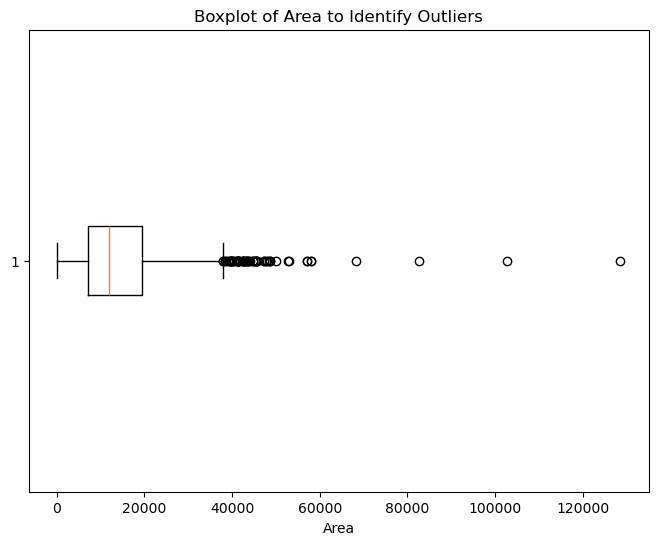

In [6]:
# Check for null values in the DataFrame
print("Null values in each column:")
null_columns = df.columns[df.isnull().any()]
if len(null_columns) > 0:
    print(f"Columns with null values: {list(null_columns)}")
else:
    print("No nulls in any column")

# Summary statistics to identify potential outliers
print("\nSummary statistics:")
print(df.describe())

# Visualize potential outliers in the 'area' column using a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df['area'], vert=False)
plt.title("Boxplot of Area to Identify Outliers")
plt.xlabel("Area")
plt.show()

1


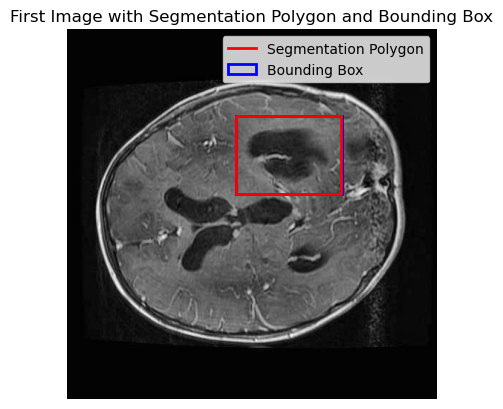

In [10]:
img_num = 5
image = df.iloc[img_num]['image']
segmentation = df.iloc[img_num]['segmentation'][0]
bbox = df.iloc[img_num]['bbox'] 
print(df.iloc[img_num]['category_id'])

fig, ax = plt.subplots(1)
ax.imshow(image)

# segmentation poly
pts = np.array(segmentation, dtype=np.int32).reshape(-1, 2)
ax.plot(pts[:, 0], pts[:, 1], color='r', linewidth=2, label='Segmentation Polygon')

# bounding box
x, y, width, height = bbox
rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='b', facecolor='none', label='Bounding Box')
ax.add_patch(rect)

plt.legend()
plt.title("First Image with Segmentation Polygon and Bounding Box")
plt.axis('off')
plt.show()

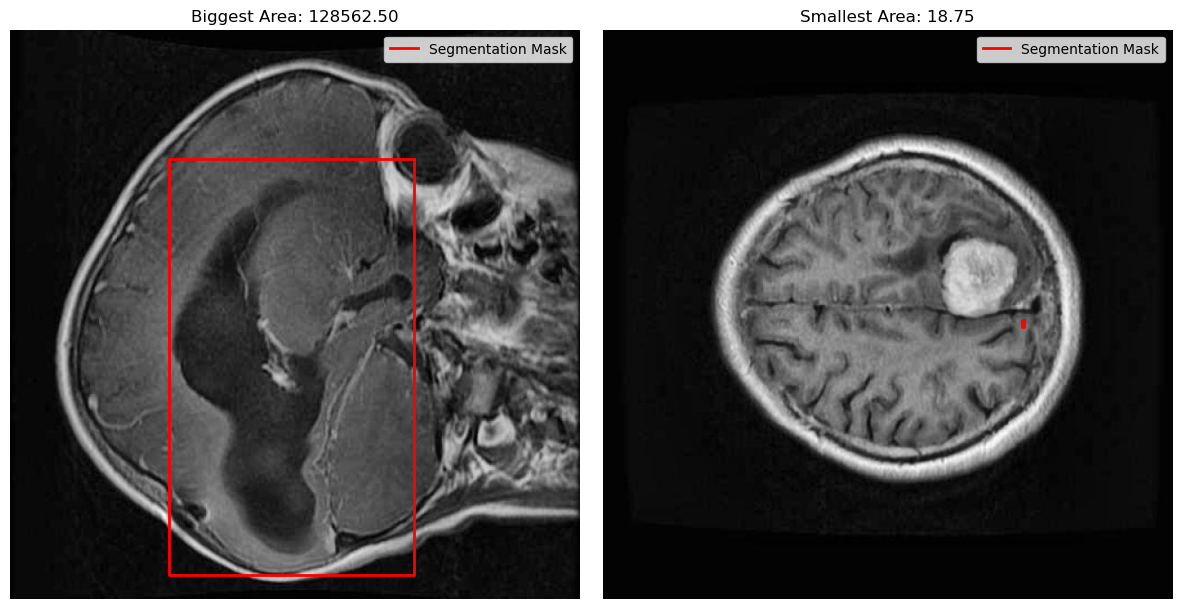

In [11]:
# Find the rows with the biggest and smallest areas
area_rows = df.loc[[df['area'].idxmax(), df['area'].idxmin()]]

# Extract the images and segmentation masks
images = [row['image'] for _, row in area_rows.iterrows()]
segmentations = [np.array(row['segmentation'][0]).reshape(-1, 2) for _, row in area_rows.iterrows()]
areas = area_rows['area'].values
titles = [f"Biggest Area: {areas[0]:.2f}", f"Smallest Area: {areas[1]:.2f}"]

# Plot the images with segmentation masks
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, image, segmentation, title in zip(axes, images, segmentations, titles):
    ax.imshow(image)
    ax.plot(segmentation[:, 0], segmentation[:, 1], color='r', linewidth=2, label='Segmentation Mask')
    ax.set_title(title)
    ax.axis('off')
    ax.legend()

plt.tight_layout()
plt.show()

# Network

In [176]:
net = ConvTumorDetector(in_channels=1, num_classes=1)
print(net)

ConvTumorDetector(
  (network): Sequential(
    (0): DownBlock(
      (model): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): GroupNorm(1, 32, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(1, 32, eps=1e-05, affine=True)
        (5): ReLU()
      )
      (skip): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 2))
    )
    (1): DownBlock(
      (model): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): GroupNorm(1, 64, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(1, 64, eps=1e-05, affine=True)
        (5): ReLU()
      )
      (skip): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
    )
    (2): DownBlock(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), 

In [177]:
summary(net, (1,640,640), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 320]              64
            Conv2d-2         [-1, 32, 320, 320]             320
         GroupNorm-3         [-1, 32, 320, 320]              64
              ReLU-4         [-1, 32, 320, 320]               0
            Conv2d-5         [-1, 32, 320, 320]           9,248
         GroupNorm-6         [-1, 32, 320, 320]              64
              ReLU-7         [-1, 32, 320, 320]               0
         DownBlock-8         [-1, 32, 320, 320]               0
            Conv2d-9         [-1, 64, 160, 160]           2,112
           Conv2d-10         [-1, 64, 160, 160]          18,496
        GroupNorm-11         [-1, 64, 160, 160]             128
             ReLU-12         [-1, 64, 160, 160]               0
           Conv2d-13         [-1, 64, 160, 160]          36,928
        GroupNorm-14         [-1, 64, 1

In [ ]:
dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation")

# load the training dataset
train_dataset = BrainTumorDataset(dataset['train'], augment=True)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

for first_image, first_mask, first_cat in train_loader:
    break

model_path = "logs/model_epoch_30.pth"
net.load_state_dict(torch.load(model_path))
net.eval() 

with torch.no_grad():
    prediction, pred_cat = net(first_image)

# Prepare data for visualization
image_np = first_image.squeeze().cpu().numpy()
ground_truth_masks = first_mask.squeeze().cpu().numpy()

predicted_cat = sigmoid_to_binary(pred_cat, threshold=0.5)
predicted_labels = clean_by_distance(prediction, threshold=0.5)

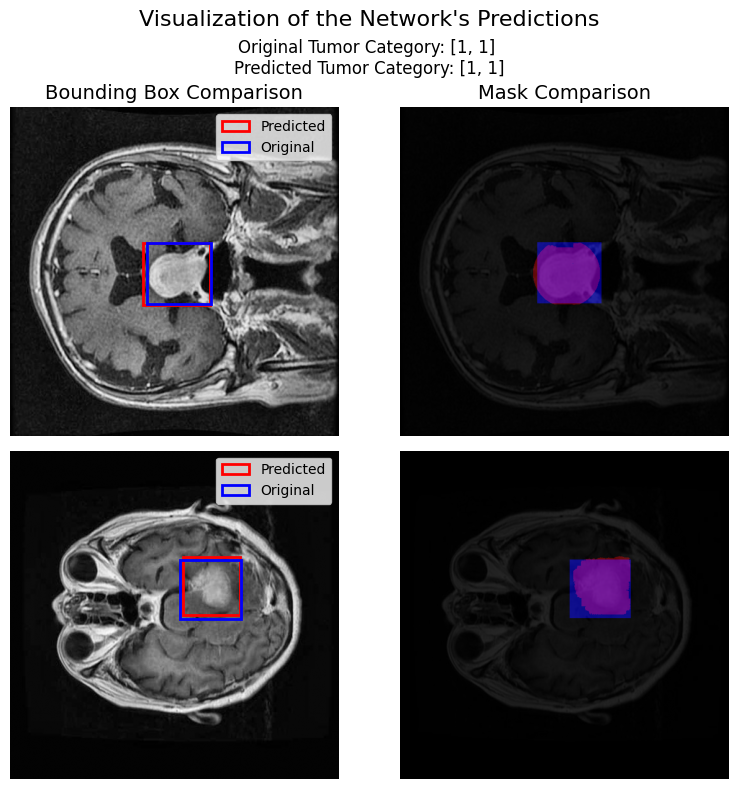

In [185]:
batch_size = 2
f,a = visualize_comparisons(
    image_np=image_np,
    pred_mask=predicted_labels,
    pred_cat=predicted_cat,
    true_mask=ground_truth_masks,
    true_cat=first_cat,
    batch_size=batch_size
)
plt.show()
plt.close(f)

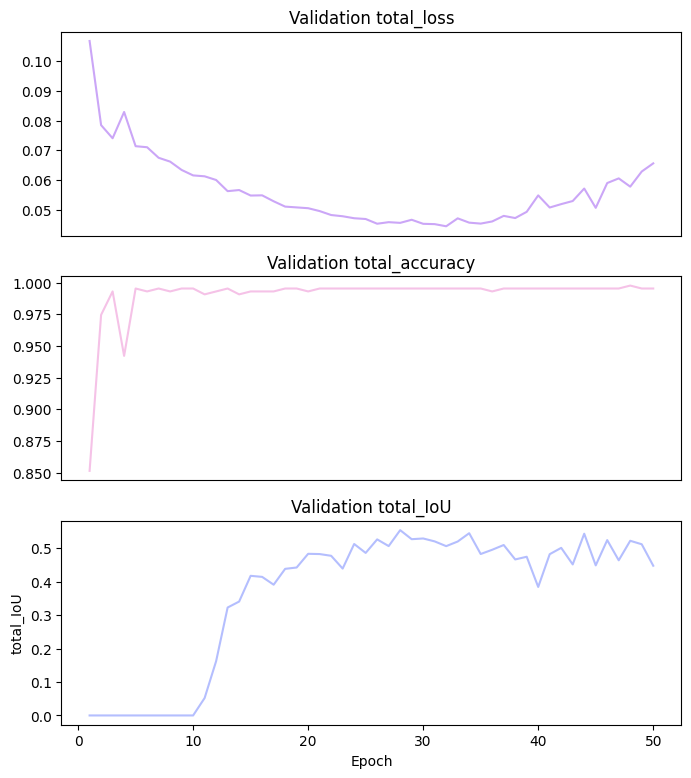

In [180]:
with open('config.json') as f:
    config = json.load(f)
pc_name = config['pc_name']

logs_dict = {}
logs_list = [
    [f'runs/May05_19-52-53_{pc_name}', 'val', 'total_loss'],
    [f'runs/May05_19-52-53_{pc_name}', 'val', 'total_accuracy'],
    [f'runs/May05_19-52-53_{pc_name}', 'val', 'total_IoU']
]

for logs in logs_list:
    logs_dict = tensorboard_log(
        logs_dict,
        logs[0], 
        logs[1], 
        logs[2],
    )

f2,a2 =visualization_of_logs(logs_dict)
plt.show()
plt.close(f2)